In [4]:
import os
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import argparse
import os
import torch

from exp.exp_informer import Exp_Informer

parser = argparse.ArgumentParser(description='[Informer] Long Sequences Forecasting')

parser.add_argument('--model', type=str, default='informer',
                    help='model of experiment, options: [informer, informerstack, informerlight(TBD)]')

parser.add_argument('--data', type=str, default='AAPL', help='data')
parser.add_argument('--root_path', type=str, default='./data/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='AAPL.csv', help='data file')
parser.add_argument('--features', type=str, default='MS',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='close', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

parser.add_argument('--seq_len', type=int, default=240, help='input sequence length of Informer encoder')
parser.add_argument('--label_len', type=int, default=70, help='start token length of Informer decoder')
parser.add_argument('--pred_len', type=int, default=35, help='prediction sequence length')
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=1, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--s_layers', type=str, default='3,2,1', help='num of stack encoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--factor', type=int, default=14, help='probsparse attn factor')
parser.add_argument('--padding', type=int, default=0, help='padding type')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--attn', type=str, default='prob', help='attention used in encoder, options:[prob, full]')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')
parser.add_argument('--mix', action='store_false', help='use mix attention in generative decoder', default=True)
parser.add_argument('--cols', type=str, nargs='+', help='certain cols from the data files as the input features')
parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=20, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=5, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=True)

parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

args = parser.parse_known_args()[0]

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

data_parser = {
    'ETTh1': {'data': 'ETTh1.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'ETTh2': {'data': 'ETTh2.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'ETTm1': {'data': 'ETTm1.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'ETTm2': {'data': 'ETTm2.csv', 'T': 'OT', 'M': [7, 7, 7], 'S': [1, 1, 1], 'MS': [7, 7, 1]},
    'WTH': {'data': 'WTH.csv', 'T': 'WetBulbCelsius', 'M': [12, 12, 12], 'S': [1, 1, 1], 'MS': [12, 12, 1]},
    'ECL': {'data': 'ECL.csv', 'T': 'MT_320', 'M': [321, 321, 321], 'S': [1, 1, 1], 'MS': [321, 321, 1]},
    'Solar': {'data': 'solar_AL.csv', 'T': 'POWER_136', 'M': [137, 137, 137], 'S': [1, 1, 1], 'MS': [137, 137, 1]},
    'AAPL': {'data': 'AAPL.csv', 'T': '70_ave', 'M': [4, 4, 4], 'S': [1, 1, 1], 'MS': [6, 6, 1]},
    'V': {'data': 'V.csv', 'T': 'close', 'M': [4, 4, 4], 'S': [1, 1, 1], 'MS': [9, 9, 1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.s_layers = [int(s_l) for s_l in args.s_layers.replace(' ', '').split(',')]
args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Exp = Exp_Informer

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model,
                                                                                                         args.data,
                                                                                                         args.features,
                                                                                                         args.seq_len,
                                                                                                         args.label_len,
                                                                                                         args.pred_len,
                                                                                                         args.d_model,
                                                                                                         args.n_heads,
                                                                                                         args.e_layers,
                                                                                                         args.d_layers,
                                                                                                         args.d_ff,
                                                                                                         args.attn,
                                                                                                         args.factor,
                                                                                                         args.embed,
                                                                                                         args.distil,
                                                                                                         args.mix,
                                                                                                         args.des, ii)

    exp = Exp(args)  # set experiments
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    if args.do_predict:
        print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.predict(setting, True)

    torch.cuda.empty_cache()

Args in experiment:
Namespace(model='informer', data='AAPL', root_path='./data/', data_path='AAPL.csv', features='MS', target='70_ave', freq='h', checkpoints='./checkpoints/', seq_len=240, label_len=70, pred_len=35, enc_in=6, dec_in=6, c_out=1, d_model=512, n_heads=8, e_layers=2, d_layers=1, s_layers=[3, 2, 1], d_ff=2048, factor=14, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=False, mix=True, cols=None, num_workers=0, itr=1, train_epochs=20, batch_size=32, patience=5, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=True, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', detail_freq='h')
Use GPU: cuda:0
>>>>>>>start training : informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>


KeyboardInterrupt: 

# prediction

In [5]:
from sklearn import preprocessing
#10 epochs Train Loss: 7.7668683 Vali Loss: 59.9697876 Test Loss: 9.6429310
# set saved model path
setting = 'informer_AAPL_ftMS_sl240_ll70_pl35_dm512_nh8_el2_dl1_df2048_atprob_fc14_ebtimeF_dtTrue_mxTrue_test_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [6]:
def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds

In [7]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

(13050, 6)


In [9]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

In [10]:
def data_stack(data,n,s):
    start=s*args.pred_len
    new_data=data[start,:,-1]
    for i in range(n):
        
        new_data=np.hstack((new_data,data[start+args.pred_len,:,-1]))
        start=start+args.pred_len
    return new_data

In [11]:
true=data_stack(trues,5,15)
pred=data_stack(preds,5,15)
#c=data_stack(close_nar,5,23)
#pred1=data_stack(preds,1,1)

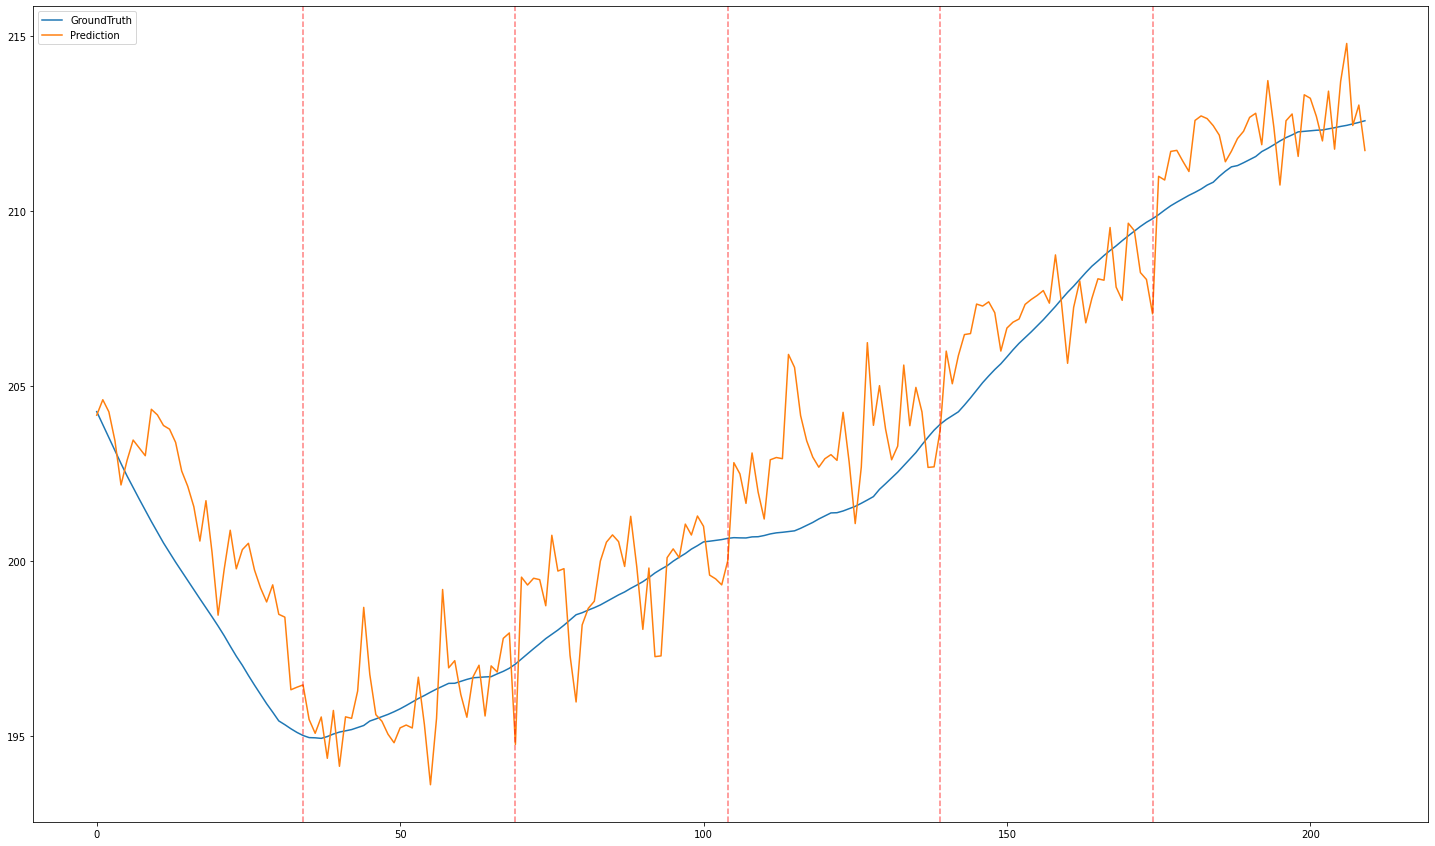

In [12]:
# draw OT prediction
#3 factors Vali Loss: 94.9354630 Test Loss: 31.3864365
plt.figure(figsize=(25,15))
plt.plot(true, label='GroundTruth')
plt.plot(pred, label='Prediction')
#plt.plot(c)
plt.axvline(34,color='red',linestyle='--',alpha=0.5)
plt.axvline(69,color='red',linestyle='--',alpha=0.5)
plt.axvline(104,color='red',linestyle='--',alpha=0.5)
plt.axvline(139,color='red',linestyle='--',alpha=0.5)
plt.axvline(174,color='red',linestyle='--',alpha=0.5)
#plt.plot(pred1, label='Prediction1')
plt.legend()
plt.show()

In [13]:
df_AAPL=pd.read_csv('F:\myproject\stock predict LSTM\informer\Informer2020-main\data\AAPL.csv')

In [14]:
df_AAPL['70_ave']=round(df_AAPL['70_ave'],4)

In [15]:
row_index=df_AAPL[df_AAPL['70_ave'] == round(float(trues[0][0]),4)].index.tolist()[0]

In [16]:
df_close=df_AAPL['close'][row_index:]

In [17]:
def straight(pred1day,start,end):
    x = np.arange(start,end)
    y = pred1day[start:end]
    n = len(x)
         
    a = (np.sum(np.power(x, 2)) * np.sum(y) - np.sum(x) * np.sum(np.multiply(np.array(x), np.array(y)))) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    b = (n * np.sum(np.multiply(np.array(x), np.array(y))) - np.sum(x) * np.sum(y)) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    #print(x)
    #print(min(x) - 1)
    #print(max(x) + 1)
    x = np.linspace(min(x) - 1, max(x) + 1, int(np.ceil(trues.shape[1]/2)))  
    p = a + b * x 
    return p,b


In [18]:
df_close_adjust=df_AAPL['close'][(row_index-args.pred_len*2):]

In [19]:
def roll_close(n):
    n_days_close=[]
    for i in range(trues.shape[0]):
        start=i
        end=i+n
        
        #print(start,end)
        n_days=df_close.values[start:end]
        
        n_days_close.append(n_days)
    return n_days_close
def roll_close_adjusted(n):
    n_days_close=[]
    for i in range(trues.shape[0]+2*args.pred_len):
        start=i
        end=i+n
        
        #print(start,end)
        n_days=df_close_adjust.values[start:end]
        #print(n_days)
        n_days_close.append(n_days)
    return n_days_close

In [20]:
close=roll_close(35)
close_adjust=roll_close_adjusted(35)

In [21]:
def cul_close1day(n):
    c=close[n*args.pred_len]
    return c

In [22]:
trues.shape[0]

1248

In [23]:
#start from week 0:
close_nar=np.array(close_adjust).reshape((trues.shape[0]+2*args.pred_len,args.pred_len,1))
day_ave_list=[]
for j in range(0,int(np.floor((trues.shape[0]+2*args.pred_len)/trues.shape[1]))):
    close_ave=np.vstack((close_nar[35*j],close_nar[35*(j+1)]))
    
    stack=close_ave[-1]
    
    end_stack=np.array([]).reshape(-1,1)
    new_day_ave_list=[]
    for i in range(1,args.pred_len+1):
        end_stack=np.vstack((end_stack,stack)).reshape(-1,1)
        
        new_day_ave=np.vstack((close_ave[i:],end_stack)).reshape(-1).sum()/(args.pred_len*2)
        
        new_day_ave_list.append(new_day_ave)
    day_ave_list.append(new_day_ave_list)

In [42]:
def get_coef(data):
    x = np.array(range(len(data))).reshape(-1, 1)
    y = np.array(data).reshape(-1, 1)
    y_qua_list=[]
    y_lin_list=[]
    pa_list=[]
    # Fit the data using polynomial regression
    for d in range(1,3):
        polynomial_features = PolynomialFeatures(degree=d)
        
        x_poly = polynomial_features.fit_transform(x)
        model = LinearRegression()
        regression = model.fit(x_poly, y)
        y_fit = regression.predict(x_poly)
    
        if d == 2:
            a = model.intercept_[0]
            d, c = model.coef_[0][1:]
            #print(f"Function of the curve: y = {a} + {d}x + {c}x^2")
            pa_list.append( c)
            y_qua_list.append(y_fit)

        
        elif d==1 :
            a = model.intercept_[0]
            b = model.coef_[0][1:][0]
            #print(f"Function of the curve: y = {a} + {b}x ")
            pa_list.append( b)
            y_lin_list.append(y_fit)
    return pa_list,y_lin_list,y_qua_list

In [44]:
get_coef(data_stack(preds,0,1))[0]

[-0.29755536247702213, 0.0018690759029252706]

In [45]:
def plot_4_curves(n,predv=True,truev=True):
    true1day=data_stack(trues,0,n)
    pred1day=data_stack(preds,0,n)
    #pred1=data_stack(preds,1,1)
    #y=pd.DataFrame(pred1day).rolling(3).mean().shift(-1)
    close1day=cul_close1day(n)
    new_ave=day_ave_list[n]
    y_lin_fit=get_coef(pred1day)[1][0]
    y_qua_fit=get_coef(pred1day)[2][0]
    b=get_coef(pred1day)[0]
    
    
    #print('Slope of curve 1 is ',b_list[0])
    #print('Slope of curve 2 is ',b_list[1])

    #print(df_p)
    
    plt.figure(figsize=(25,15))
    if predv:
        plt.plot( pred1day, label='pred values')
        plt.plot( y_qua_fit, 'r',label='polyfit values')
        plt.plot( y_lin_fit, 'deeppink',label='slope')
    elif truev:
        plt.plot( pred1day, label='pred values')
        plt.plot( y_qua_fit, 'r',label='polyfit values')
        plt.plot(true1day, label='GroundTruth')
        plt.plot( y_lin_fit, 'deeppink',label='slope')
    else:   
        plt.plot( pred1day, label='pred values')
        plt.plot( y_qua_fit, 'r',label='polyfit values')
        plt.plot(true1day, label='GroundTruth')
        plt.plot( close1day,label='close values',color='yellowgreen')
        plt.plot( y_lin_fit, 'deeppink',label='slope')
        plt.plot( new_ave, 'green',label='new_ave')
    plt.legend()
    plt.show()
    return b

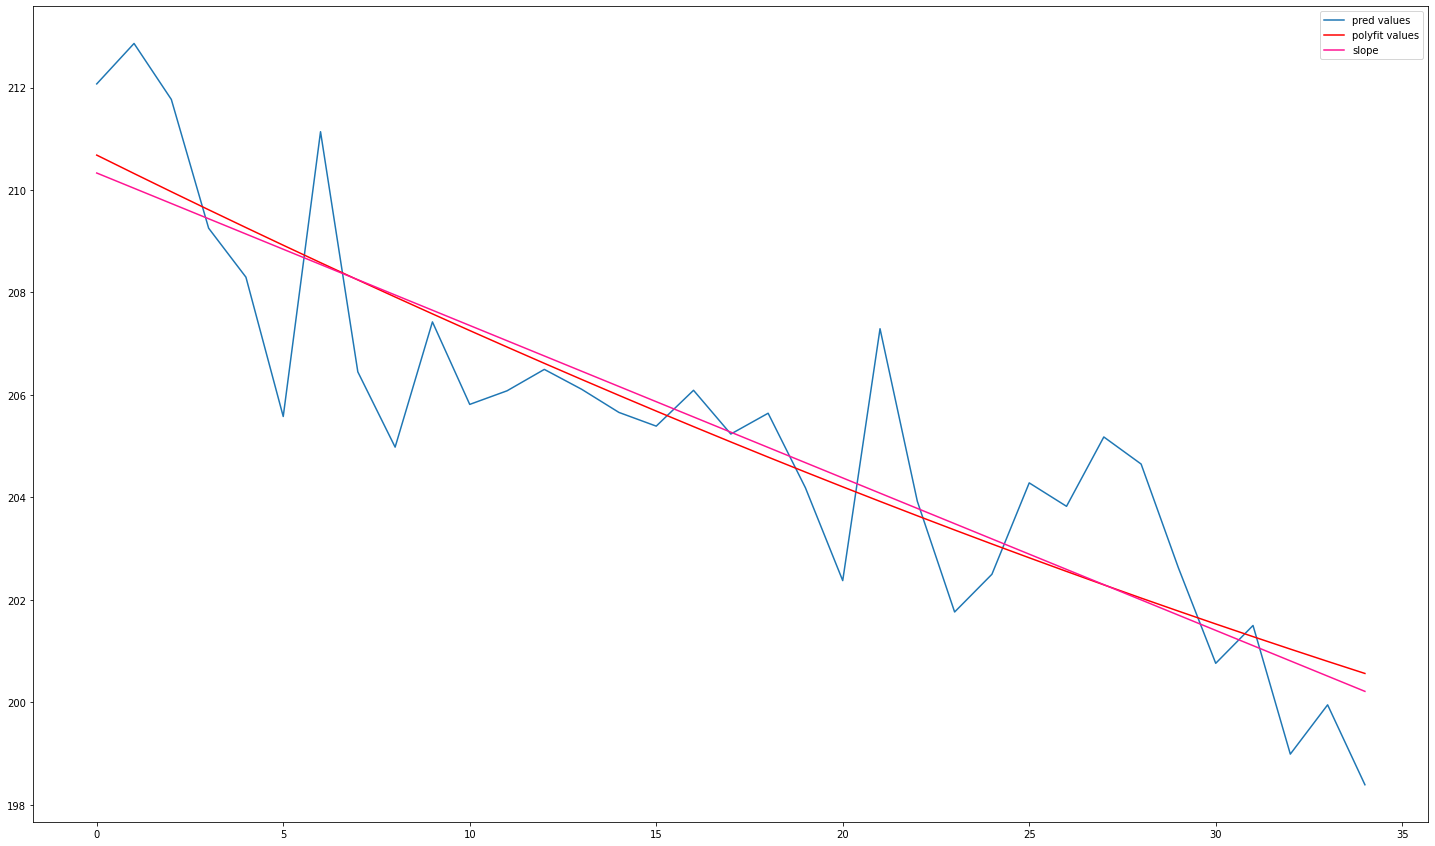

[-0.29755536247702213, 0.0018690759029252706]

In [46]:
plot_4_curves(1,predv=True,truev=False)

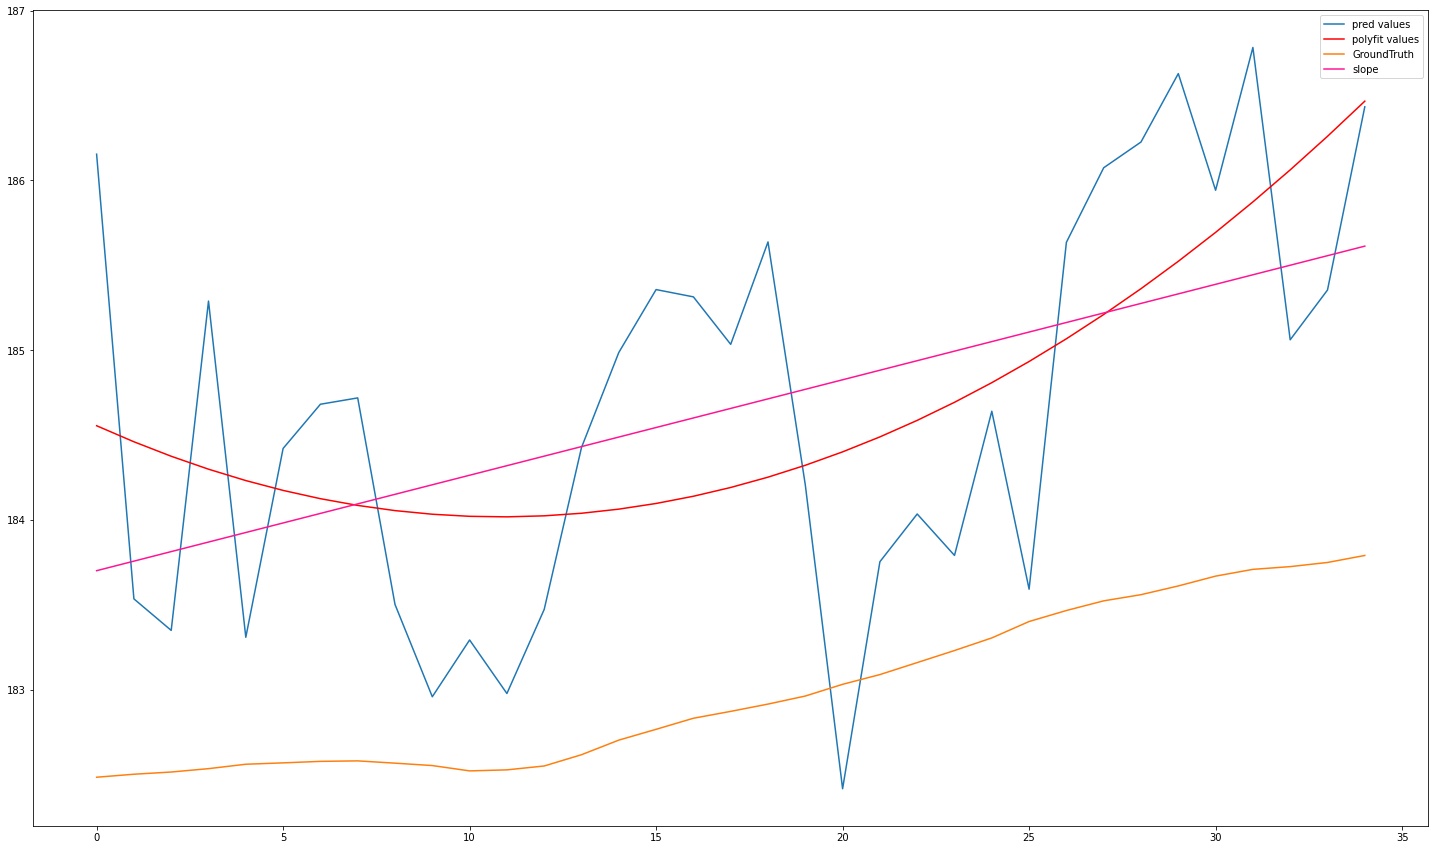

[0.0562518678125547, 0.004568035429833884]

In [47]:
plot_4_curves(31,predv=False,truev=True)

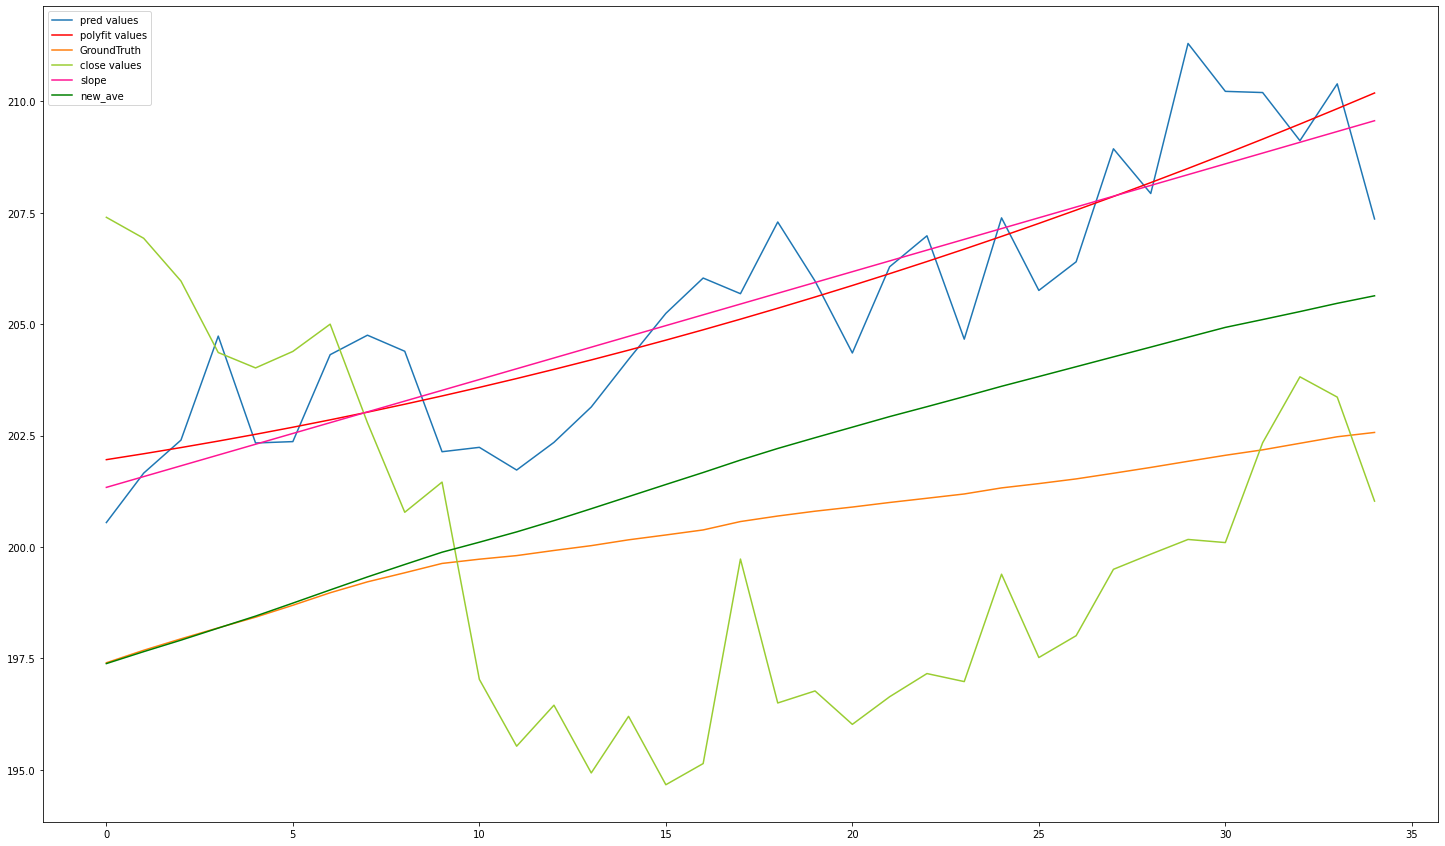

[0.24202647489659923, 0.003326772231514332]

In [58]:
plot_4_curves(34,predv=False,truev=False)

In [49]:
i=31
print('true:',get_coef(data_stack(trues,0,i))[0][0])
print('ave:',get_coef(day_ave_list[i])[0][0])

true: 0.04339786818047531
ave: 0.01428744977991071


# culculate returns

In [59]:
def true_slope(n):
    list1day=data_stack(trues,0,n)
    p_list=[]
    b_list=[]
    for i in range(0,2):
        start=int(i*int(np.ceil(trues.shape[1]/2)))
        end=int(start+int(np.floor(trues.shape[1]/2)))
        p,b=straight(list1day,start,end)
        p_list.append(p)
        b_list.append(b)
    #print('Slope of curve 1 is ',b_list[0])
    #print('Slope of curve 2 is ',b_list[1])
    p_new=np.vstack((p_list[0],p_list[1])).reshape(-1)
    df_p=pd.DataFrame(p_new)
    df_p.iloc[17]=None
    return b_list

In [60]:
def pred_slope(n):
    list1day=data_stack(preds,0,n)
    p_list=[]
    b_list=[]
    for i in range(0,2):
        start=int(i*int(np.ceil(trues.shape[1]/2)))
        end=int(start+int(np.floor(trues.shape[1]/2)))
        p,b=straight(list1day,start,end)
        p_list.append(p)
        b_list.append(b)
    #print('Slope of curve 1 is ',b_list[0])
    #print('Slope of curve 2 is ',b_list[1])
    p_new=np.vstack((p_list[0],p_list[1])).reshape(-1)
    df_p=pd.DataFrame(p_new)
    df_p.iloc[17]=None
    return b_list

In [61]:
def get_slope_lists(data,alpha1=0.05,alpha2=0.05):
    
     
    #alpha1 #(two slope downward)the larger the alphal1 the less the model make a buy decision and more to make a sell decision 
    #alpha2 #(two slope upward)the larger the alphal2 the more the model make a buy decision and less to make a sell decision 
    score_list=[]
    class_list=[]
    s=0
    for i in range(0,int(len(trues)/35)+1):
        target=get_coef(data_stack(data,0,i))[0][0]
        
        ave=get_coef(day_ave_list[i])[0][0]
        if target <=ave:
            s=0
            c='down'
        else :
            s=1
            c='up'
        score_list.append(s)
        class_list.append(c)
    return score_list,class_list

In [62]:
def get_true_slope_lists(true_slope):
    
     
    #trues slope has a different standard from preds
    score_list=[]
    s=0
    for i in range(int(len(trues)/35)):
        if true_slope(i)[0]<0 and true_slope(i)[1]<0 and true_slope(i)[0]>true_slope(i)[1]:
            s=0
            
            #print(i,true_slope(i)[0],true_slope(i)[1])
        elif true_slope(i)[0]<0 and true_slope(i)[1]<0 and true_slope(i)[0]<true_slope(i)[1]:
            s=0
            #both negative and curve up 

        elif true_slope(i)[0]>0 and true_slope(i)[1]<0:
            s=0
        
        elif true_slope(i)[0]<0 and true_slope(i)[1]>0:
            s=1
            
        elif true_slope(i)[0]>0 and true_slope(i)[1]>0 and true_slope(i)[0]<true_slope(i)[1]:
            s=1
            
        elif true_slope(i)[0]>0 and true_slope(i)[1]>0 and true_slope(i)[0]>true_slope(i)[1]:
            s=0
            
        score_list.append(s)
        
    return score_list

In [63]:
def get_best_beta1and2(pred_slope,c_list):
    beta_list=np.linspace(0.01,0.2,20)
    best_beta1=0
    best_beta2=0

    best_accuracy=0
    for beta1 in beta_list:
        for beta2 in beta_list:
            a_list=[]
            true_class_list=[]
            pred_class_list=[]

            for i in range(int(len(trues)/35)):
                if pred_slope(i)[0]<0 and pred_slope(i)[1]<0 and pred_slope(i)[0]<pred_slope(i)[1] and (pred_slope(i)[1]-pred_slope(i)[0])<=beta1:
                    pred_class_list.append(0)
                    a_list.append(i)
                elif pred_slope(i)[0]<0 and pred_slope(i)[1]<0 and pred_slope(i)[0]<pred_slope(i)[1] and (pred_slope(i)[1]-pred_slope(i)[0])>beta1:
                    pred_class_list.append(1)
                    a_list.append(i)
                elif pred_slope(i)[0]>0 and pred_slope(i)[1]>0 and pred_slope(i)[0]>pred_slope(i)[1] and (pred_slope(i)[0]-pred_slope(i)[1])<beta2:
                    pred_class_list.append(1)
                    a_list.append(i)
                elif pred_slope(i)[0]>0 and pred_slope(i)[1]>0 and pred_slope(i)[0]>pred_slope(i)[1] and (pred_slope(i)[0]-pred_slope(i)[1])>=beta2:
                    pred_class_list.append(0)
                    a_list.append(i)

            for i in a_list:
                true_class_list.append(c_list[i])
            class_accuracy=get_acc(true_class_list,pred_class_list)
            if best_accuracy<class_accuracy:
                best_beta1=beta1
                best_beta2=beta2
            else: 
                best_beta1=best_beta1
                best_beta2=best_beta2
            best_accuracy=max(best_accuracy,class_accuracy)
    print('the best beta1 is {},the best beta2 is {}'.format(best_beta1,best_beta2))
            
    return best_accuracy,best_beta1,best_beta2
        

In [64]:
def get_acc(true,pred):
    correct=0    

    for i in range(len(true)):
        correct+=np.bool_((true[i]==(pred[i]))).sum().item()
    
        acc=(correct)/(len(true))
    return acc

In [66]:
# plot confusion matrix
classes1=['down','up']
classes2=['0','1']
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(predictions,targets,classes,title):
  cm = confusion_matrix(y_true=targets,y_pred=predictions)
  df_cm = pd.DataFrame(data=cm,columns=classes,index=classes)
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm,xticklabels=classes,yticklabels=classes,annot=True)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title(title)
  plt.show()

In [67]:
c_list=get_slope_lists(trues)[0]
prediction_list=get_slope_lists(preds)[0].copy()

In [68]:
#best_accuracy,best_beta1,best_beta2=get_best_beta1and2(pred_slope,c_list)

In [69]:
#set alpha1 and alpha2:
#alpha1=best_beta1
#alpha2=best_beta2

In [70]:
pred_class=get_slope_lists(preds)[1]
true_class=get_slope_lists(trues)[1]

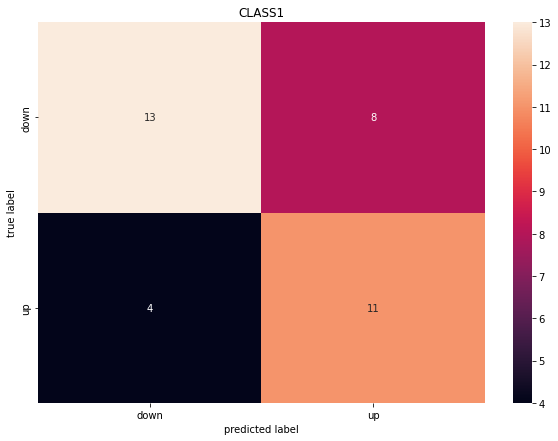

In [71]:
# no class8
plot_cm(pred_class,true_class,classes1,'CLASS1')

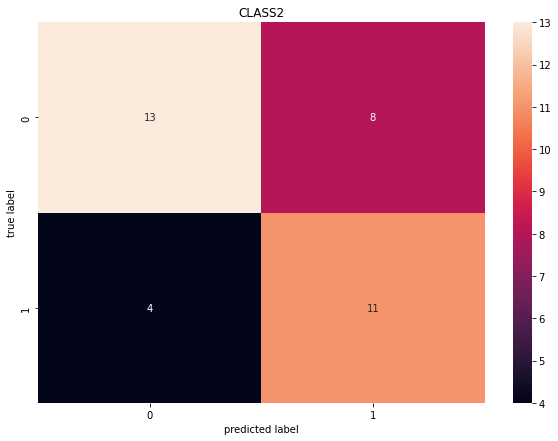

In [82]:
plot_cm(prediction_list,c_list,classes2,'CLASS2')

In [83]:
accuracy=get_acc(c_list,prediction_list)
accuracy

0.6666666666666666

# set strategy

In [1596]:
df_close

11745    208.92
11746    208.97
11747    208.97
11748    207.53
11749    209.74
          ...  
13045    211.15
13046    211.68
13047    212.41
13048    211.78
13049    211.76
Name: close, Length: 1305, dtype: float64

In [1597]:
df_AAPL=pd.read_csv('F:\myproject\stock predict LSTM\informer\Informer2020-main\data\AAPL.csv')
df_AAPL['70_ave']=round(df_AAPL['70_ave'],4)
row_index=df_AAPL[df_AAPL['70_ave'] == round(float(trues[0][0]),4)].index.tolist()[0]
df_close=df_AAPL['close'][row_index:]
df_close

11745    208.92
11746    208.97
11747    208.97
11748    207.53
11749    209.74
          ...  
13045    211.15
13046    211.68
13047    212.41
13048    211.78
13049    211.76
Name: close, Length: 1305, dtype: float64

In [1598]:
def straight(pred1day,start,end):
    x = np.arange(start,end)
    y = pred1day[start:end]
    n = len(x)
         
    a = (np.sum(np.power(x, 2)) * np.sum(y) - np.sum(x) * np.sum(np.multiply(np.array(x), np.array(y)))) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    b = (n * np.sum(np.multiply(np.array(x), np.array(y))) - np.sum(x) * np.sum(y)) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    x = np.linspace(min(x) - 1, max(x) + 1, int(np.ceil(trues.shape[1]/2)))  
    p = a + b * x 
    return p,b
def roll_close(n):
    n_days_close=[]
    for i in range(trues.shape[0]):
        start=i
        end=i+n
        
        #print(start,end)
        n_days=df_close.values[start:end]
        n_days_close.append(n_days)
    return n_days_close

In [1599]:
close=roll_close(35)

In [1600]:
def cul_close1day(n):
    c=close[n*args.pred_len]
    return c

In [1601]:
def straight_true(true1day,start,end):
    x = np.arange(start,end)
    y = true1day[start:end]
    n = len(x)
         
    a = (np.sum(np.power(x, 2)) * np.sum(y) - np.sum(x) * np.sum(np.multiply(np.array(x), np.array(y)))) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    b = (n * np.sum(np.multiply(np.array(x), np.array(y))) - np.sum(x) * np.sum(y)) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    x = np.linspace(min(x) - 1, max(x) + 1, int(np.ceil(trues.shape[1]/2)))  
    p = a + b * x 

    return p,b

In [1602]:
def true_slope(n,show_value=True):
    true1day=data_stack(trues,0,n)
    p_true_list=[]
    b_true_list=[]
    for i in range(0,2):
        start=int(i*int(np.ceil(trues.shape[1]/2)))
        end=int(start+int(np.floor(trues.shape[1]/2)))
        p,b=straight_true(true1day,start,end)
        p_true_list.append(p)
        b_true_list.append(b)
    if show_value is True:  
        print('Slope of true curve1 is ',b_true_list[0])
        print('Slope of true curve2 is ',b_true_list[1])
    p_true_new=np.vstack((p_true_list[0],p_true_list[1])).reshape(-1)
    df_p_true=pd.DataFrame(p_true_new)
    df_p_true.iloc[17]=None
    return df_p_true, b_true_list

In [1603]:
def straight_pred(pred1day,start,end):
    x = np.arange(start,end)
    y = pred1day[start:end]
    n = len(x)
         
    a = (np.sum(np.power(x, 2)) * np.sum(y) - np.sum(x) * np.sum(np.multiply(np.array(x), np.array(y)))) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    b = (n * np.sum(np.multiply(np.array(x), np.array(y))) - np.sum(x) * np.sum(y)) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    x = np.linspace(min(x) - 1, max(x) + 1, int(np.ceil(trues.shape[1]/2)))  
    p = a + b * x 
    return p,b

In [1604]:
def pred_slope(n,show_value=True):
    pred1day=data_stack(preds,0,n)
    p_pred_list=[]
    b_pred_list=[]
    for i in range(0,2):
        start=start=int(i*int(np.ceil(trues.shape[1]/2)))
        end=int(start+int(np.floor(trues.shape[1]/2)))
        
        p,b=straight_pred(pred1day,start,end)
        p_pred_list.append(p)
        b_pred_list.append(b)
    if show_value is True:    
        print('Slope of pred curve 1 is ',b_pred_list[0])
        print('Slope of pred curve 2 is ',b_pred_list[1])
    p_new=np.vstack((p_pred_list[0],p_pred_list[1])).reshape(-1)
    df_p_pred=pd.DataFrame(p_new)
    df_p_pred.iloc[17]=None
    return df_p_pred,b_pred_list

In [1605]:
df_p_true=true_slope(2)[0]
df_p_pred=pred_slope(2)[0]

Slope of true curve1 is  0.028616587320963543
Slope of true curve2 is  0.34136252309761794
Slope of pred curve 1 is  -0.20592210807052314
Slope of pred curve 2 is  0.13122053707347198


In [1606]:
def get_slope_list(get_true=False,get_pred=False):
    if get_pred:
        pred_slope_list=[]
        for i in range(int(len(trues)/35)):
            p=pred_slope(i,show_value=False)[1]
            pred_slope_list.append(p)
        return pred_slope_list
    if get_true:
        true_slope_list=[]
        for i in range(int(len(trues)/35)):
            q=true_slope(i,show_value=False)[1]
            true_slope_list.append(q)    
        return true_slope_list

In [1607]:
p_list=get_slope_list(get_pred=True)
t_list=get_slope_list(get_true=True)

In [1608]:
p_list

[[-0.15585188772164138, -0.15437814301135494],
 [-0.4114179050221163, -0.3475702697155522],
 [-0.20592210807052314, 0.13122053707347198],
 [0.1723782782461129, 0.3035471673105277],
 [0.13774718490301394, 0.08351961771647136],
 [0.27570806765088846, 0.07010583316578585],
 [0.10044299854951746, -0.19164571575089998],
 [-0.017232782700482535, -0.09415959376914829],
 [-0.19889558530321308, -0.14114084430769377],
 [-0.18556841681985295, -0.15651646782370174],
 [-0.2732037936939913, -0.25295066833496094],
 [0.017540015426336552, 0.055054608513327205],
 [0.08685347613166361, 0.0740657507204542],
 [0.1369183484245749, 0.21284125832950368],
 [0.05260516147987515, -0.026015711765663297],
 [-0.08999540291580499, -0.2547732708500881],
 [0.018719243068321078, 0.05412457036037071],
 [0.03513654073079427, 0.05582738390155867],
 [0.08199474858302697, 0.019675946703144147],
 [0.10511428234623928, 0.06969605240167356],
 [0.08075874926997166, 0.03214054481655944],
 [-0.14264600417193243, -0.0282941706040

In [1609]:
def get_accuracy(t_list,p_list):
    correct=0
    for i in range(len(t_list)):
        for j in range(len(t_list[0])):
            true=np.where(t_list[i][j]>0,1,0)
            pred=np.where(p_list[i][j]>0,1,0)
            correct+=(true==(pred)).sum().item()
            acc=(correct)/(len(t_list)*2)
    return acc
        

In [1610]:
acc=get_accuracy(t_list,p_list)

In [1611]:
t_list

[[-0.271876054651597, -0.4278730130663105],
 [-0.24855415493834251, -0.21863406312231923],
 [0.028616587320963543, 0.34136252309761794],
 [0.24895660549986595, 0.2786935544481464],
 [0.19087600708007812, 0.14227201424393],
 [0.04206616270775888, -0.06361149806602329],
 [-0.15677377289416744, -0.17167730892405791],
 [-0.056621738508635874, -0.11066709780225567],
 [0.07607650756835938, -0.09732799904019225],
 [-0.12790335860906862, -0.19767211465274587],
 [-0.3275923261455461, -0.09642073687385111],
 [-0.11551640080470665, 0.13192547068876379],
 [0.1946569330552045, 0.13619299495921416],
 [0.2332142474604588, 0.1440411735983456],
 [-0.1612258985930798, -0.2501549440271714],
 [-0.3182903364592907, -0.2419902203129787],
 [0.060446645699295344, 0.05185994914933747],
 [0.11333256141812194, 0.09694652931362975],
 [0.0428770850686466, 0.1619393591787301],
 [0.18546145570044423, 0.1562681759105009],
 [0.10490099589029948, 0.0415189032461129],
 [-0.06832051744648054, -0.003133699005725337],
 [-0

In [1612]:
acc

0.8285714285714286

In [1613]:
def get_price(trues_value):
    x=trues_value[0]
    for i in range(1,len(trues_value)):
        x=np.vstack((x,trues_value[i][-1]))
    return x

In [1614]:
close_price=get_price(trues)

In [1615]:
df_strategy=pd.DataFrame(close_price,columns={'ave_close'})
df_strategy=df_strategy[:len(t_list)*35]
df_date=df_AAPL['date'][row_index:][:len(t_list)*35]

In [1616]:
df_try=df_strategy.copy()
df_close=df_AAPL['close'][row_index:][:len(t_list)*35]

In [1617]:
df_strategy['close']=df_close.values

In [1618]:
def get_signal(t_list,p_list):
    tt=[]
    pp=[]
    for i in range(len(t_list)):
            for j in range(len(t_list[0])):
                true=np.where(t_list[i][j]>0,1,0)
                pred=np.where(p_list[i][j]>0,1,0)
                tt.append(true)
                pp.append(pred)
    return tt,pp      

In [1619]:
tt,pp=get_signal(t_list,p_list)

In [1620]:
def fill_none(tt_list,j_list):
    n=int(len(trues[0]))
    in_index=0
    for i in range((len(tt_list))):
        for j in range(j_list[i]):
            tt_list.insert(in_index,np.nan)
        for k in range(n-1-j_list[i]):
            tt_list.insert(in_index+1+j_list[i],np.nan)

        in_index=in_index+n
    return tt_list

In [1621]:
'''n=int(len(trues[0]))
in_index=0
for i in range((len(pr_list))):
    for j in range(pr_j_list[i]):
        pr_list.insert(in_index,np.nan)
    for k in range(n-1-pr_j_list[i]):
        pr_list.insert(in_index+1+pr_j_list[i],np.nan)

    in_index=in_index+n'''

'n=int(len(trues[0]))\nin_index=0\nfor i in range((len(pr_list))):\n    for j in range(pr_j_list[i]):\n        pr_list.insert(in_index,np.nan)\n    for k in range(n-1-pr_j_list[i]):\n        pr_list.insert(in_index+1+pr_j_list[i],np.nan)\n\n    in_index=in_index+n'

In [1622]:
#tt_filled=fill_none(score_list)


In [1623]:
#len(tt_filled)

In [1624]:
#tt_filled

In [1625]:
df_strategy['date']=df_date.values
#df_strategy['true_signal']=tt_filled
#df_strategy['pred_signal']=pp_filled
df_strategy=df_strategy.fillna(method='ffill')
df_strategy['delta_price']=(df_strategy.close-df_strategy.close.shift(1))/df_strategy.close.shift(1)
df_strategy=df_strategy.dropna(axis=0)
#df_strategy['pred_return']=df_strategy.delta_price*df_strategy.pred_signal
#df_strategy['true_return']=df_strategy.delta_price*df_strategy.true_signal
df_strategy['market_total_return']=np.cumprod(1+df_strategy.delta_price)-1
#df_strategy['pred_total_return']=np.cumprod(1+df_strategy.pred_return)-1
#df_strategy['true_total_return']=np.cumprod(1+df_strategy.true_return)-1

In [1626]:
df_strategy

ave_close    close             date  delta_price  market_total_return
1     220.457886  208.970   2022/3/1 15:00     0.000239             0.000239
2     220.226608  208.970   2022/3/1 16:00     0.000000             0.000239
3     219.941177  207.530   2022/3/2 10:00    -0.006891            -0.006653
4     219.670456  209.740   2022/3/2 11:00     0.010649             0.003925
5     219.395325  208.830   2022/3/2 12:00    -0.004339            -0.000431
...          ...      ...              ...          ...                  ...
1220  202.058975  200.100  2022/11/7 16:00    -0.000350            -0.042217
1221  202.181259  202.340  2022/11/8 10:00     0.011194            -0.031495
1222  202.328125  203.820  2022/11/8 11:00     0.007314            -0.024411
1223  202.474838  203.365  2022/11/8 12:00    -0.002232            -0.026589
1224  202.571701  201.030  2022/11/8 13:00    -0.011482            -0.037766

[1224 rows x 5 columns]

In [1627]:
#df_strategy[['true_total_return','market_total_return']].plot(grid=True,figsize=(15,8))

In [1628]:
#need to find out the tradable price
def get_tradable_list(c_list):
    #selected tradable dates
    n=int(len(trues[0]))
    buy_barrir=0.02
    sell_barrir=0.04
    in_index=0
    s_list=[]
    s_index=0
    j_index_list=[]
    for i in range(1,(len(t_list))):
        j_index=0
        for j in range(0,14):
            #print(df_strategy.close[i*n+j])

            if c_list[i]==1:
                if df_strategy.close[i*n+j]-df_strategy.ave_close[i*n+j]<buy_barrir*df_strategy.ave_close[i*n+j]:
                    
                    s_index=1
                    j_index=j
                    #print(i,j)
                    break
                elif i>1 and (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n])/df_strategy.close[(i-1)*n] < -0.05:
                    s_index=0
                    j_index=j
                    #print(i)
                else:
                    s_index=np.nan

            elif c_list[i-1]==1 and c_list[i]==0:
                if df_strategy.ave_close[i*n+j]-df_strategy.close[i*n+j]<sell_barrir*df_strategy.ave_close[i*n+j]:
                    s_index=0
                    j_index=j
                    #print(i,j)
                    break
                #stop loss trigger
                elif i>1 and (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n])/df_strategy.close[(i-1)*n] < -0.05:
                #elif (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n+j])/df_strategy.close[(i-1)*n+j] > 0.20:
                    s_index=0
                    j_index=j
                    #print(i)
                    break
                else: 
                    s_index=np.nan
                    #print(i)
                    
            elif c_list[i-1]==0 and c_list[i]==0:
                if df_strategy.ave_close[i*n+j]-df_strategy.close[i*n+j]<sell_barrir*df_strategy.ave_close[i*n+j]:
                    s_index=0
                    j_index=j
                
                    #print(i,j)
                    break
                elif i>1 and (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n])/df_strategy.close[(i-1)*n] < -0.05:
                #elif (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n+j])/df_strategy.close[(i-1)*n+j] > 0.20:
                    s_index=0
                    j_index=j
                    #print(i)
                    break
                
                    
                    
            else:
                s_index=np.nan
        #print(i,j_index)
        s_list.append(s_index)
        j_index_list.append(j_index)
            #print(c_list[i])
    return s_list,j_index_list

In [1629]:
s_list=get_tradable_list(c_list)[0]
s_j_list=get_tradable_list(c_list)[1]

In [1630]:
pr_list=get_tradable_list(prediction_list)[0]
pr_j_list=get_tradable_list(prediction_list)[1]

In [1631]:
pr_list_copy=pr_list.copy()

In [1632]:
pr_filled=fill_none(pr_list,pr_j_list)

In [1633]:
pr_filled[540]

nan

In [1634]:
s_filled=fill_none(s_list,s_j_list)


In [1635]:
len(pr_filled)

1190

In [1636]:
df_strategy=df_strategy[34:]
df_strategy['real_signal']=s_filled
df_strategy['pr_signal']=pr_filled
df_strategy=df_strategy.fillna(method='ffill')
df_strategy=df_strategy.fillna(value=0)
#df_strategy['delta_close']=(df_strategy.close-df_strategy.close.shift(1))/df_strategy.close.shift(1)
df_strategy=df_strategy.dropna(axis=0)
df_strategy['real_return']=df_strategy.delta_price*df_strategy.real_signal
df_strategy['pr_return']=df_strategy.delta_price*df_strategy.pr_signal
df_strategy['real_total_return']=np.cumprod(1+df_strategy.real_return)-1
df_strategy['pr_total_return']=np.cumprod(1+df_strategy.pr_return)-1

In [1637]:
df_strategy[50:100]

ave_close     close             date  delta_price  market_total_return  \
85   200.486267  213.4500  2022/3/17 15:00     0.003526             0.021683   
86   200.558136  212.0000  2022/3/17 16:00    -0.006793             0.014742   
87   200.792862  213.6600  2022/3/18 10:00     0.007830             0.022688   
88   201.035141  214.8500  2022/3/18 11:00     0.005570             0.028384   
89   201.272995  216.8899  2022/3/18 12:00     0.009495             0.038148   
90   201.519424  217.1800  2022/3/18 13:00     0.001338             0.039537   
91   201.787003  217.2700  2022/3/18 14:00     0.000414             0.039967   
92   202.057709  219.0900  2022/3/18 15:00     0.008377             0.048679   
93   202.326431  218.8100  2022/3/18 16:00    -0.001278             0.047339   
94   202.686005  216.9200  2022/3/21 10:00    -0.008638             0.038292   
95   203.062500  217.6100  2022/3/21 11:00     0.003181             0.041595   
96   203.420639  216.1400  2022/3/21 12:00    -0.006755             0.034559   
97   203.760574  216.3300  2022/3/21 13:00     0.000879             0.035468   
98   204.095718  215.7200  2022/3/21 14:00    -0.002820             0.032548   
99   204.472565  217.1200  2022/3/21 15:00     0.006490             0.039249   
100  204.865005  217.9700  2022/3/21 16:00     0.003915             0.043318   
101  205.277710  219.1600  2022/3/22 10:00     0.005459             0.049014   
102  205.676147  218.2800  2022/3/22 11:00    -0.004015             0.044802   
103  205.995422  217.8600  2022/3/22 12:00    -0.001924             0.042791   
104  206.365433  218.2200  2022/3/22 13:00     0.001652             0.044515   
105  206.714645  217.9200  2022/3/22 14:00    -0.001375             0.043079   
106  207.099640  218.5100  2022/3/22 15:00     0.002707             0.045903   
107  207.475784  218.0300  2022/3/22 16:00    -0.002197             0.043605   
108  207.753494  216.7500  2022/3/23 10:00    -0.005871             0.037478   
109  208.019928  216.0200  2022/3/23 11:00    -0.003368             0.033984   
110  208.247635  215.5100  2022/3/23 12:00    -0.002361             0.031543   
111  208.479706  214.9000  2022/3/23 13:00    -0.002830             0.028623   
112  208.704422  214.8300  2022/3/23 14:00    -0.000326             0.028288   
113  208.915146  214.5900  2022/3/23 15:00    -0.001117             0.027140   
114  209.127136  214.3200  2022/3/23 16:00    -0.001258             0.025847   
115  209.358932  214.9750  2022/3/24 10:00     0.003056             0.028982   
116  209.615356  216.2500  2022/3/24 11:00     0.005931             0.035085   
117  209.870148  215.0650  2022/3/24 12:00    -0.005480             0.029413   
118  210.126434  215.9400  2022/3/24 13:00     0.004069             0.033601   
119  210.379776  216.2800  2022/3/24 14:00     0.001575             0.035229   
120  210.653625  217.1900  2022/3/24 15:00     0.004208             0.039585   
121  210.929916  217.3100  2022/3/24 16:00     0.000553             0.040159   
122  211.206772  218.2500  2022/3/25 10:00     0.004326             0.044658   
123  211.478058  216.7600  2022/3/25 11:00    -0.006827             0.037526   
124  211.756058  217.7500  2022/3/25 12:00     0.004567             0.042265   
125  212.031631  217.7200  2022/3/25 13:00    -0.000138             0.042121   
126  212.312347  218.1900  2022/3/25 14:00     0.002159             0.044371   
127  212.619919  218.3100  2022/3/25 15:00     0.000550             0.044945   
128  212.928497  217.7600  2022/3/25 16:00    -0.002519             0.042313   
129  213.139496  218.9700  2022/3/28 10:00     0.005557             0.048105   
130  213.358841  217.8050  2022/3/28 11:00    -0.005320             0.042528   
131  213.606201  218.1350  2022/3/28 12:00     0.001515             0.044108   
132  213.870483  218.5900  2022/3/28 13:00     0.002086             0.046286   
133  214.135559  219.7550  2022/3/28 14:00     0.005330             0.051862   
134  2

<AxesSubplot:>

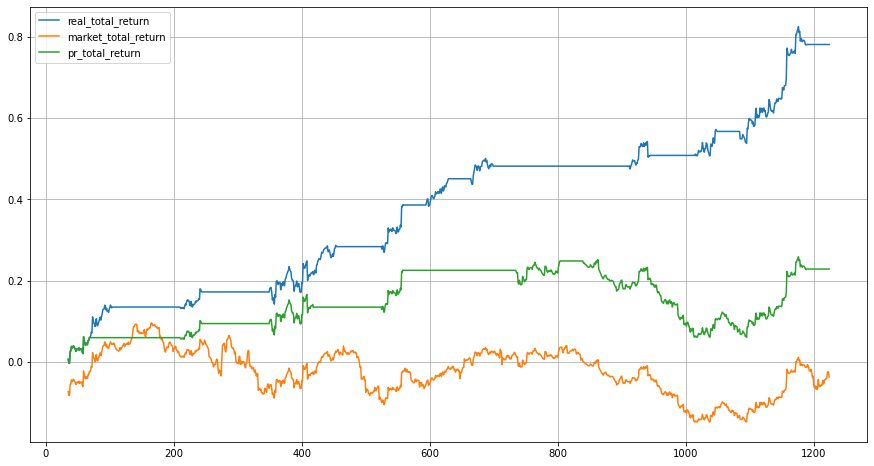

In [1638]:
df_strategy[['real_total_return','market_total_return','pr_total_return']].plot(grid=True,figsize=(15,8))

In [1639]:
df_strategy.to_csv('./data/appl_res.csv')

In [1640]:
df_strategy

ave_close    close             date  delta_price  market_total_return  \
35    208.428833  193.475   2022/3/8 14:00     0.006006            -0.073928   
36    208.003693  191.560   2022/3/8 15:00    -0.009898            -0.083094   
37    207.570831  191.700   2022/3/8 16:00     0.000731            -0.082424   
38    207.252060  197.310   2022/3/9 10:00     0.029264            -0.055572   
39    206.939621  197.370   2022/3/9 11:00     0.000304            -0.055284   
...          ...      ...              ...          ...                  ...   
1220  202.058975  200.100  2022/11/7 16:00    -0.000350            -0.042217   
1221  202.181259  202.340  2022/11/8 10:00     0.011194            -0.031495   
1222  202.328125  203.820  2022/11/8 11:00     0.007314            -0.024411   
1223  202.474838  203.365  2022/11/8 12:00    -0.002232            -0.026589   
1224  202.571701  201.030  2022/11/8 13:00    -0.011482            -0.037766   

      real_signal  pr_signal  real_return  pr_return  real_total_return  \
35            1.0        1.0     0.006006   0.006006           0.006006   
36            1.0        1.0    -0.009898  -0.009898          -0.003952   
37            1.0        1.0     0.000731   0.000731          -0.003224   
38            1.0        1.0     0.029264   0.029264           0.025946   
39            1.0        1.0     0.000304   0.000304           0.026258   
...           ...        ...          ...        ...                ...   
1220          0.0        0.0    -0.000000  -0.000000           0.781516   
1221          0.0        0.0     0.000000   0.000000           0.781516   
1222          0.0        0.0     0.000000   0.000000           0.781516   
1223          0.0        0.0    -0.000000  -0.000000           0.781516   
1224          0.0        0.0    -0.000000  -0.000000           0.781516   

      pr_total_return  
35           0.006006  
36          -0.003952  
37          -0.003224  
38           0.025946  
39           0.026258  
...               ...  
1220         0.228320  
1221         0.228320  
1222         0.228320  
1223         0.228320  
1224         0.228320  

[1190 rows x 11 columns]

In [1641]:
df_strategy.pr_total_return.values

array([ 0.00600562, -0.00395175, -0.00322379, ...,  0.22831957,
        0.22831957,  0.22831957])

In [1642]:
def add_stop_point(alpha):
    #alpha=max loss threshold
    stack=0
    stop_points_list=[]
    for i in range(len(df_strategy.pr_total_return)):
        
        stop_point=0
        pred_return=df_strategy.pr_total_return.values[i]
        
        if df_strategy.pr_signal.values[i]==1:
            if df_strategy.pr_signal.values[i-1]==0:
                stack=pred_return
            else:
                
                stack=max(pred_return,stack)
                
                
                if stack-pred_return>alpha:
                    stop_point=i
                    stack=0
                    stop_points_list.append(stop_point)
                    print(stop_point,stack,pred_return)
        else:
            stack=0
    return stop_points_list
            

In [1643]:
stop_points_list=add_stop_point(0.1)
stop_points_list

927 0 0.14877607821341843


[927]

In [1644]:
#sign stop points into prediction signals
for j in stop_points_list:
    while pr_list[j] != 0 and j<len(pr_list)-1: 
        
        #print(j)
        pr_list[j]=0
        j+=1 

In [1645]:
pr_list_adjusted=pr_list

In [1646]:
df_strategy['pr_signal_adjusted']=pr_list_adjusted
df_strategy=df_strategy.fillna(method='ffill')
df_strategy=df_strategy.fillna(value=0)
df_strategy['pr_return_adjusted']=df_strategy.delta_price*df_strategy.pr_signal_adjusted
df_strategy['pr_total_return_adjusted']=np.cumprod(1+df_strategy.pr_return_adjusted)-1

In [1647]:
df_strategy

ave_close    close             date  delta_price  market_total_return  \
35    208.428833  193.475   2022/3/8 14:00     0.006006            -0.073928   
36    208.003693  191.560   2022/3/8 15:00    -0.009898            -0.083094   
37    207.570831  191.700   2022/3/8 16:00     0.000731            -0.082424   
38    207.252060  197.310   2022/3/9 10:00     0.029264            -0.055572   
39    206.939621  197.370   2022/3/9 11:00     0.000304            -0.055284   
...          ...      ...              ...          ...                  ...   
1220  202.058975  200.100  2022/11/7 16:00    -0.000350            -0.042217   
1221  202.181259  202.340  2022/11/8 10:00     0.011194            -0.031495   
1222  202.328125  203.820  2022/11/8 11:00     0.007314            -0.024411   
1223  202.474838  203.365  2022/11/8 12:00    -0.002232            -0.026589   
1224  202.571701  201.030  2022/11/8 13:00    -0.011482            -0.037766   

      real_signal  pr_signal  real_return  pr_return  real_total_return  \
35            1.0        1.0     0.006006   0.006006           0.006006   
36            1.0        1.0    -0.009898  -0.009898          -0.003952   
37            1.0        1.0     0.000731   0.000731          -0.003224   
38            1.0        1.0     0.029264   0.029264           0.025946   
39            1.0        1.0     0.000304   0.000304           0.026258   
...           ...        ...          ...        ...                ...   
1220          0.0        0.0    -0.000000  -0.000000           0.781516   
1221          0.0        0.0     0.000000   0.000000           0.781516   
1222          0.0        0.0     0.000000   0.000000           0.781516   
1223          0.0        0.0    -0.000000  -0.000000           0.781516   
1224          0.0        0.0    -0.000000  -0.000000           0.781516   

      pr_total_return  pr_signal_adjusted  pr_return_adjusted  \
35           0.006006                 1.0            0.006006   
36          -0.003952                 1.0           -0.009898   
37          -0.003224                 1.0            0.000731   
38           0.025946                 1.0            0.029264   
39           0.026258                 1.0            0.000304   
...               ...                 ...                 ...   
1220         0.228320                 0.0           -0.000000   
1221         0.228320                 0.0            0.000000   
1222         0.228320                 0.0            0.000000   
1223         0.228320                 0.0           -0.000000   
1224         0.228320                 0.0           -0.000000   

      pr_total_return_adjusted  
35                    0.006006  
36                   -0.003952  
37                   -0.003224  
38                    0.025946  
39                    0.026258  
...                        ...  
1220                  0.162307  
1221                  0.162307  
1222                  0.162307  
1223                  0.162307  
1224                  0.162307  

[1190 rows x 14 columns]

<AxesSubplot:>

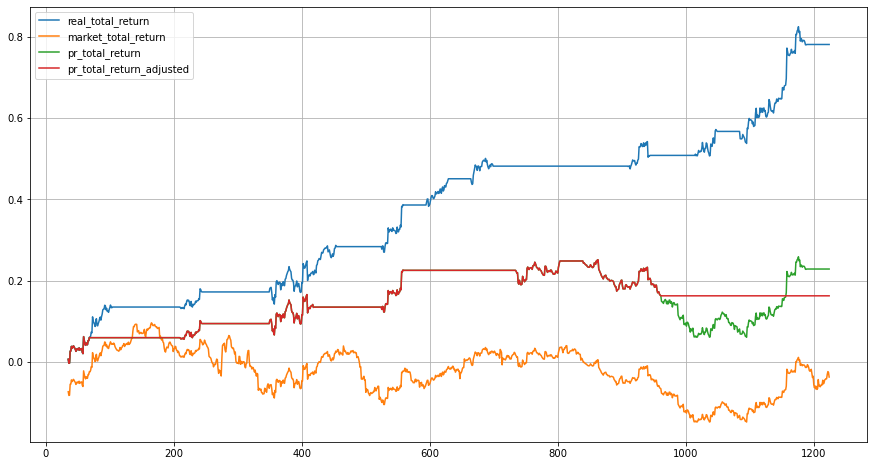

In [1648]:
df_strategy[['real_total_return','market_total_return','pr_total_return','pr_total_return_adjusted']].plot(grid=True,figsize=(15,8))

In [1649]:
#Calculating CAGR and Sharp Ratio
from datetime import datetime

In [1650]:
df_strategy_copy=df_strategy.copy()
df_strategy_copy=df_strategy_copy.set_index(np.arange(len(df_strategy_copy)))
start_val=1
end_val=df_strategy_copy.pr_total_return_adjusted.values[-1]+1
days=int(len(df_date)/6)-1
years=days/350

In [1651]:
annual_return=(end_val-start_val)/start_val/(years)
CAGR=(end_val/start_val)**(1/years)-1
sharp_ratio=(df_strategy_copy.pr_total_return_adjusted.values.mean()/df_strategy_copy.pr_total_return_adjusted.values.std())*np.sqrt(360)

In [1652]:
print('annual_reurn: ',annual_return*100,
     'CAGR: ',CAGR*100,
     'sharp_ratio: ',sharp_ratio)

annual_reurn:  27.983882447319175 CAGR:  29.605028100732888 sharp_ratio:  46.9703544674066


# CUSTOMIZED Data

In [297]:
from data.data_loader import Dataset_Custom
from data.data_loader import Dataset_Pred
from data.data_loader import Dataset_ETT_minute
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
prediction_signal_list=[]

In [298]:
args.root_path = './data/AAPL_stock/'
args.data_path = 'AAPL_PRE.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [299]:
df

date     open       low      high    close   volume  \
0      2015/6/24 16:00   68.860   68.8600   68.8600   68.860     9233   
1      2015/6/25 10:00   68.790   68.7350   68.9700   68.940   451698   
2      2015/6/25 11:00   68.940   68.7800   69.0500   68.840   415236   
3      2015/6/25 12:00   68.830   68.6800   68.8400   68.730   273057   
4      2015/6/25 13:00   68.740   68.7068   68.8400   68.800   299829   
...                ...      ...       ...       ...      ...      ...   
13407   2023/2/9 12:00  230.020  229.4200  230.6150  230.040   361407   
13408   2023/2/9 13:00  230.085  229.8000  230.8098  230.145   330993   
13409   2023/2/9 14:00  230.120  229.7900  230.3100  229.940   348490   
13410   2023/2/9 15:00  229.940  229.1250  229.9700  229.340  1082401   
13411   2023/2/9 16:00  229.350  229.3500  229.3500  229.350   161447   

           70_ave  
0       69.103043  
1       69.094614  
2       69.082186  
3       69.066043  
4       69.049043  
...           ...  
13407  229.731559  
13408  229.812773  
13409  229.890344  
13410  229.955487  
13411  229.974630  

[13412 rows x 7 columns]

In [300]:
df_list=['6','5','4','3','2','1','0']
for i in range(7,0,-1):
    df[:-35*(i-1)].to_csv('F:\myproject\stock predict LSTM\informer\Informer2020-main\data\AAPL_stock/AAPL_'+df_list[i-1]+'.csv',index=False)

In [301]:
def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
    #print(pred_data)
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))
        #print(best_model_path)
    exp.model.eval()
        
    preds = []
    
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)
        #print(batch_y)
        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
       
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        #print(pred)
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds

In [302]:
df_list_new=['0','1','2','3','4','5']
prediction_list=[]
for i in range(0,6):
    args.root_path = './data/AAPL_stock/'
    args.data_path = 'AAPL_'+df_list_new[i]+'.csv'
    args.target = '70_ave'
    args.freq = 'h'

    Data = Dataset_Custom
    timeenc = 0 if args.embed!='timeF' else 1
    flag = 'val'; shuffle_flag = False; drop_last = True; batch_size = 1

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        inverse=True,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        timeenc=timeenc,
        target=args.target, # HULL here
        freq=args.freq # 'h': hourly, 't':minutely
    )
    data_loader = DataLoader(
        data_set,

        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    prediction = predict(exp, setting, True)
    scaler = StandardScaler()
    scaler.fit(df.iloc[:,6:])
    df_scaled = scaler.transform(df.iloc[:,6:])
    prediction_inverse=scaler.inverse_transform(prediction[0,:])
    prediction_list.append(prediction_inverse)

(13202, 6)
(13237, 6)
(13272, 6)
(13307, 6)
(13342, 6)
(13377, 6)


In [303]:
df_com=pd.read_csv('./data/AAPL_stock/AAPL_PRE.csv')
df_com=df_com[-210:]
predict_l=[item for list in prediction_list for item in list]
pred_val=[x[0] for x in predict_l]
df_com['pred']=pred_val

In [304]:
df_com

date     open       low      high    close   volume  \
13202  2022/12/28 10:00  207.860  206.8500  208.2495  206.960   388056   
13203  2022/12/28 11:00  206.900  206.0843  207.0000  206.110   311493   
13204  2022/12/28 12:00  206.040  205.2000  206.3100  206.220   400448   
13205  2022/12/28 13:00  206.230  205.8200  206.7700  205.916   259469   
13206  2022/12/28 14:00  205.880  205.5000  206.1700  205.630   243661   
...                 ...      ...       ...       ...      ...      ...   
13407    2023/2/9 12:00  230.020  229.4200  230.6150  230.040   361407   
13408    2023/2/9 13:00  230.085  229.8000  230.8098  230.145   330993   
13409    2023/2/9 14:00  230.120  229.7900  230.3100  229.940   348490   
13410    2023/2/9 15:00  229.940  229.1250  229.9700  229.340  1082401   
13411    2023/2/9 16:00  229.350  229.3500  229.3500  229.350   161447   

           70_ave        pred  
13202  207.430869  208.073013  
13203  207.312667  207.006332  
13204  207.212381  209.542694  
13205  207.100610  209.489365  
13206  206.988037  209.273178  
...           ...         ...  
13407  229.731559  229.691757  
13408  229.812773  233.906876  
13409  229.890344  231.787216  
13410  229.955487  230.388519  
13411  229.974630  229.549133  

[210 rows x 8 columns]

In [305]:
df_com.index.values[34]

13236

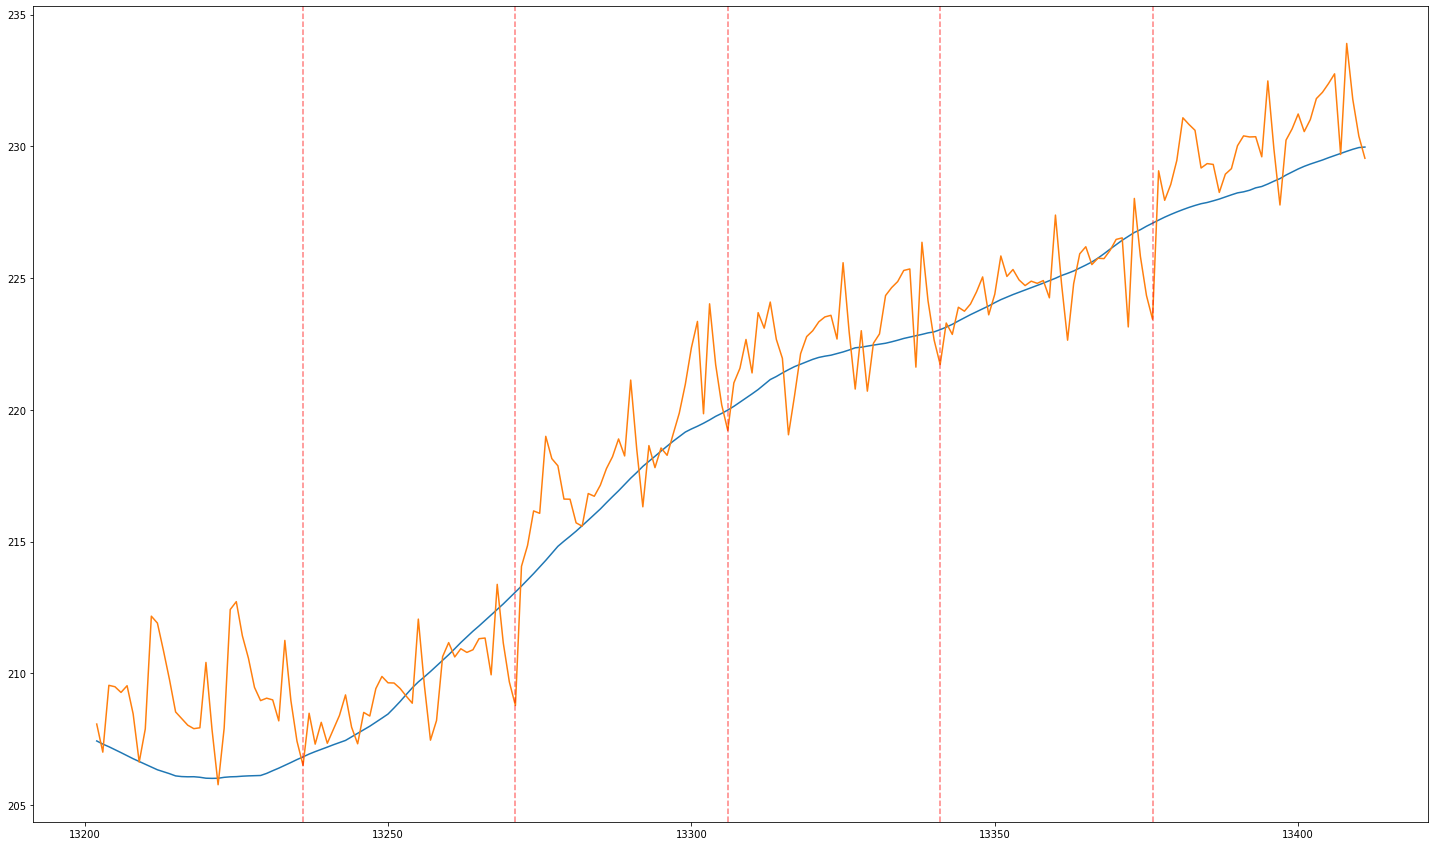

In [306]:
plt.figure(figsize=(25,15))
plt.plot(df_com['70_ave'], label='GroundTruth')
plt.plot(df_com['pred'], label='Prediction')
plt.axvline(df_com.index.values[34],color='red',linestyle='--',alpha=0.5)
plt.axvline(df_com.index.values[69],color='red',linestyle='--',alpha=0.5)
plt.axvline(df_com.index.values[104],color='red',linestyle='--',alpha=0.5)
plt.axvline(df_com.index.values[139],color='red',linestyle='--',alpha=0.5)
plt.axvline(df_com.index.values[174],color='red',linestyle='--',alpha=0.5)

# let's check week by week

In [733]:
#week1 Nov_28-----Dec_02
#week2 Dec_05-----Dec_09
#week3 Dec_12-----Dec_16
#week4 Dec_19-----Dec_23
#week5 Dec_23-----Dec_30 # Cr vacation
#week6 Dec_30-----Jan_06 #new year vvacation
#week7 Jan_09-----Jan_13
#week8 Jan_13-----Jan_20
#week9Jan_23-----Jan_27
n=8#number of weeks since nov.23
#df_week=df[:13090+35*n]
#df_week_true=df[(13090+35*n):13090+35*(n+1)].reset_index()['70_ave']
#df_week.to_csv('F:\myproject\stock predict LSTM\informer\Informer2020-main\data\AAPL_stock/df_week1.csv',index=False)
num_week=f'df_week{n}.csv'
df_week_true=pd.read_csv( f'./data/AAPL_stock/df_week{(n+1)}.csv')[-35:].reset_index()['70_ave']

In [734]:
args.root_path = './data/AAPL_stock/'
args.data_path = num_week
args.target = '70_ave'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'val'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        inverse=True,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        timeenc=timeenc,
        target=args.target, # HULL here
        freq=args.freq # 'h': hourly, 't':minutely
    )
data_loader = DataLoader(
        data_set,

        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
prediction = predict(exp, setting, True)
scaler = StandardScaler()
scaler.fit(df.iloc[:,6:])
df_scaled = scaler.transform(df.iloc[:,6:])
prediction_inverse=scaler.inverse_transform(prediction[0,:])

(13314, 6)


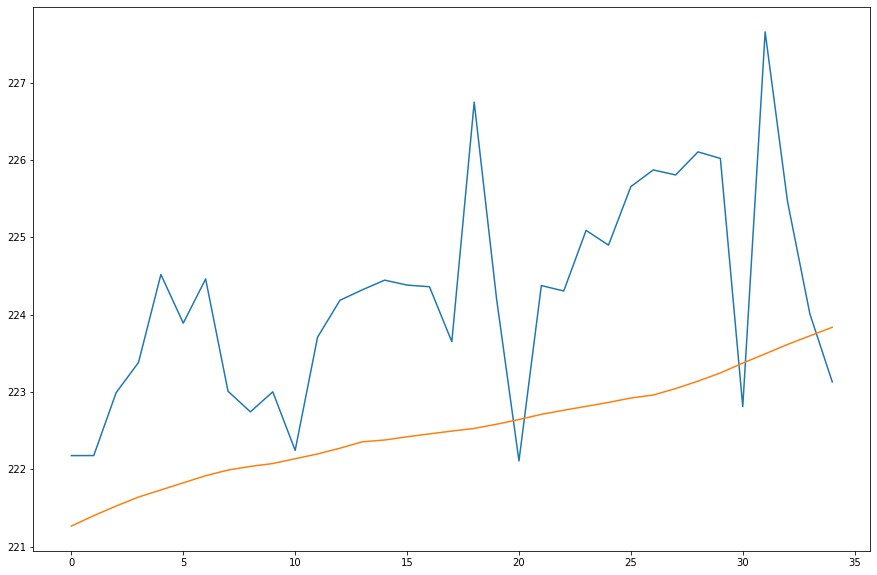

In [735]:
plt.figure(figsize=(15,10))
plt.plot(prediction_inverse)
plt.plot(df_week_true)
plt.show()
#check plot_4_curves(16,predv=False,truev=True)

# Suggestions based on prediction

In [736]:
def plot_prediction_curves(pred):
    #true1day=data_stack(trues,0,n)
    #pred1day=data_stack(preds,0,n)
    #pred1=data_stack(preds,1,1)
    y=pd.DataFrame(pred[:,-1]).rolling(3).mean().shift(-1)
    
    
    p_list=[]
    b_list=[]
    for i in range(0,2):
        start=int(i*int(np.ceil(trues.shape[1]/2)))
        end=int(start+int(np.floor(trues.shape[1]/2)))
        p,b=straight_pred(pred[:,-1],start,end)
        p_list.append(p)
        b_list.append(b)
    print('Slope of curve 1 is ',b_list[0])
    print('Slope of curve 2 is ',b_list[1])
    p_new=np.vstack((p_list[0],p_list[1])).reshape(-1)
    df_p=pd.DataFrame(p_new)
    df_p.iloc[17]=None
    
    
    plt.figure(figsize=(25,15))
    
    plt.plot( pred[:,-1], label='pred values')
    plt.plot( y, 'r',label='polyfit values')
    plt.plot( df_p, 'deeppink',label='slope')
    
    plt.legend()
    plt.show()
    return b_list

Slope of curve 1 is  0.09804721907073376
Slope of curve 2 is  0.01372221404430913


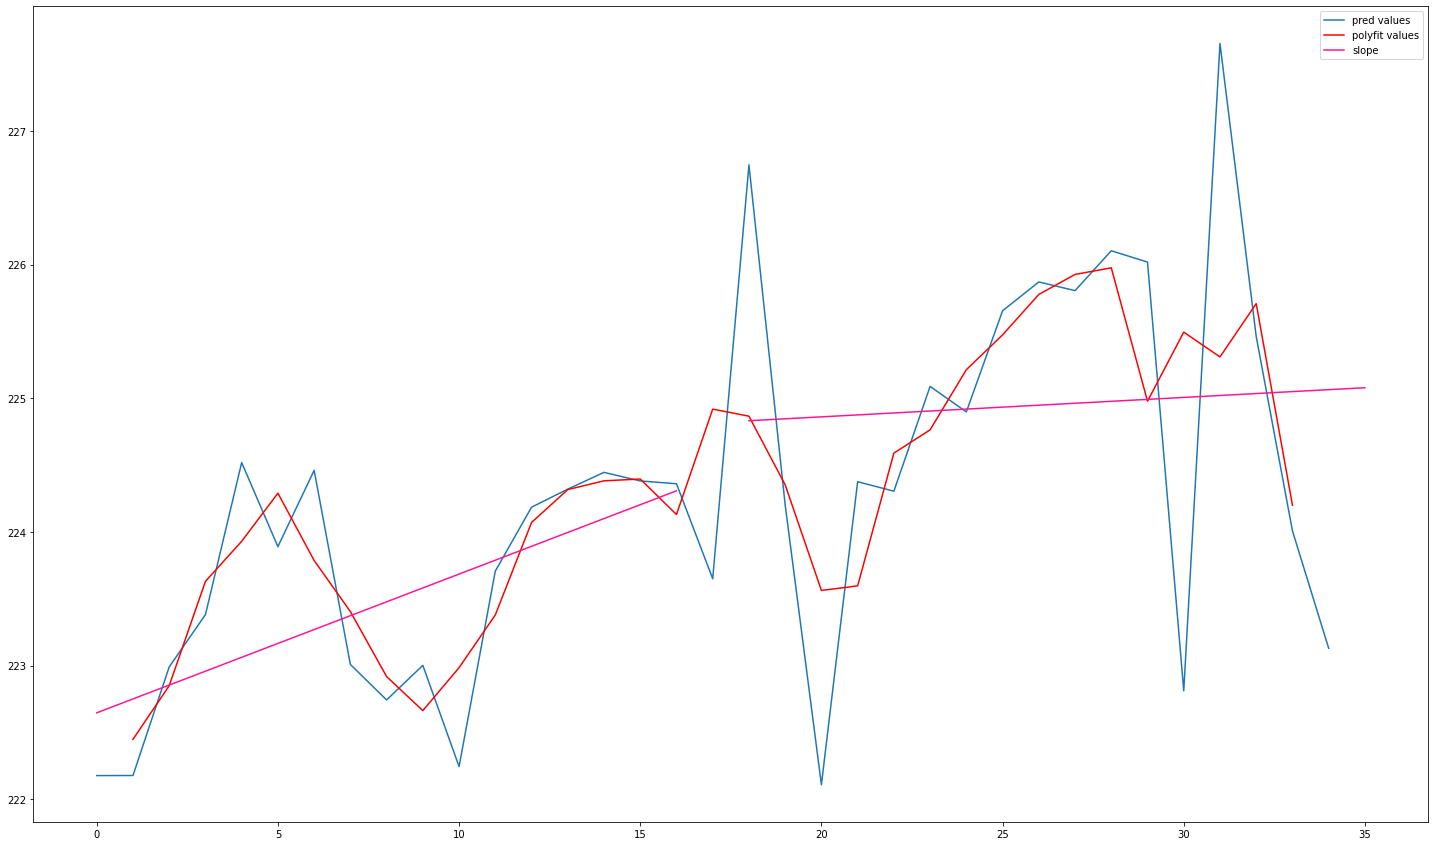

In [737]:
predictions_slope=plot_prediction_curves(prediction_inverse)

Slope of curve 1 is  0.07149354338234991
Slope of curve 2 is  0.07991432818626307


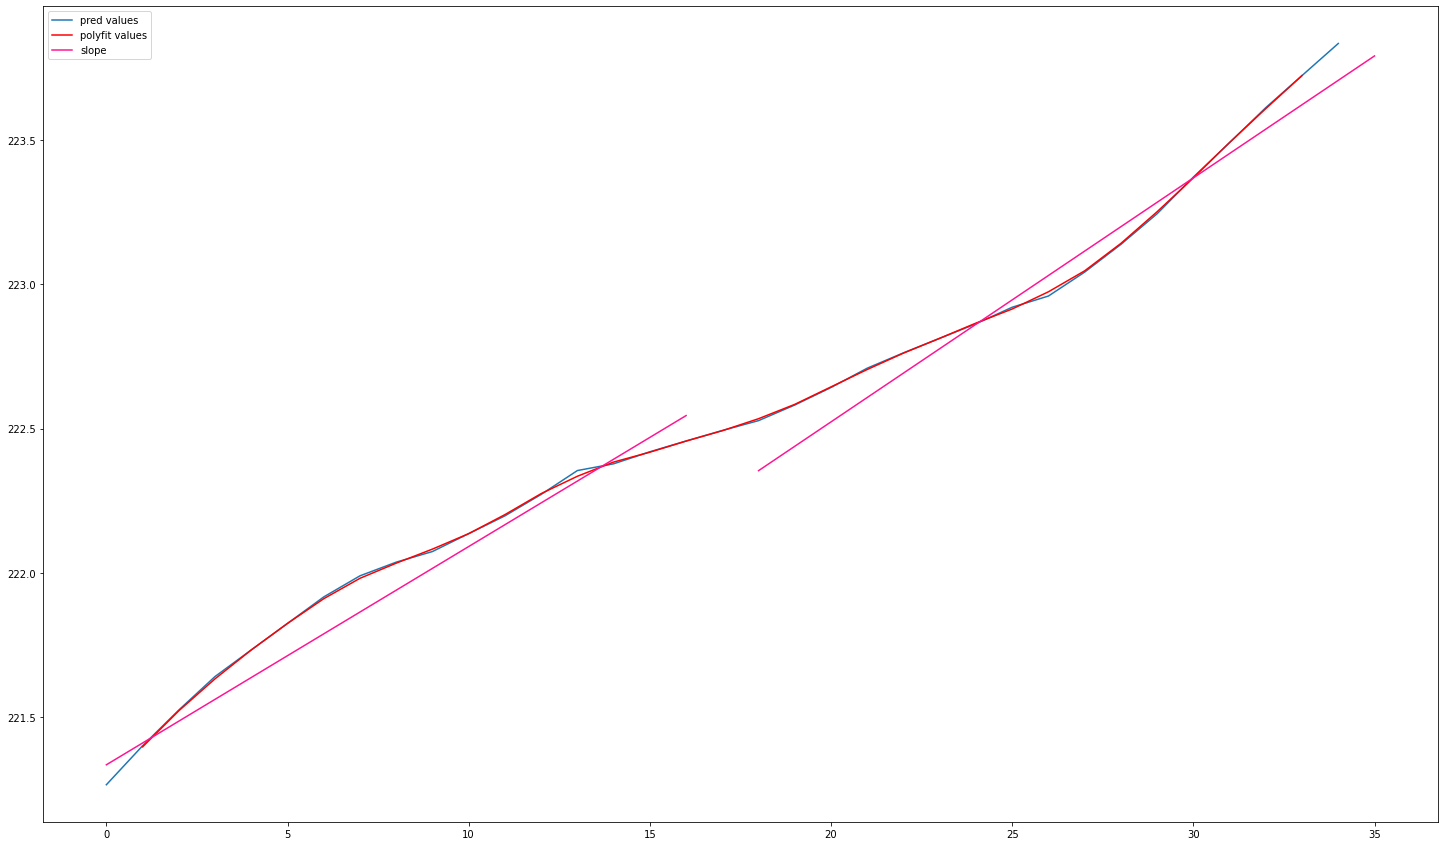

In [738]:
real_slope=plot_prediction_curves(df_week_true.values.reshape(-1,1))

In [739]:
def get_predicions_signal(true_slope,alpha1=0.05,alpha2=0.05):
    
     
    #alpha1 #(two slope downward)the larger the alphal1 the less the model make a buy decision and more to make a sell decision 
    #alpha2 #(two slope upward)the larger the alphal2 the more the model make a buy decision and less to make a sell decision 
    score_list=[]
    
    s=0
    
    if true_slope[0]<0 and true_slope[1]<0 and true_slope[0]>true_slope[1]:
        s=0
        #both negative and curve down
        #print(i,true_slope(i)[0],true_slope(i)[1])
    elif true_slope[0]<0 and true_slope[1]<0 and true_slope[0]<true_slope[1] and (true_slope[1]-true_slope[0])<=alpha1:
        s=0
        #both negative and curve up but angle is smaller than 0.2.
    elif true_slope[0]<0 and true_slope[1]<0 and true_slope[0]<true_slope[1] and (true_slope[1]-true_slope[0])>alpha1: 
        s=1
        #both negative and curve up but angle is larger than 0.2.
    elif true_slope[0]>0 and true_slope[1]<0:
        s=0

    elif true_slope[0]<0 and true_slope[1]>0:
        s=1

    elif true_slope[0]>0 and true_slope[1]>0 and true_slope[0]<true_slope[1]:
        s=1

    elif true_slope[0]>0 and true_slope[1]>0 and true_slope[0]>true_slope[1] and (true_slope[0]-true_slope[1])<alpha2:
        s=1
        
    elif true_slope[0]>0 and true_slope[1]>0 and true_slope[0]>true_slope[1] and (true_slope[0]-true_slope[1])>=alpha2:
        s=0

    score_list.append(s)
        
    return score_list

In [740]:
prediction_signal=get_predicions_signal(predictions_slope,alpha1=alpha1,alpha2=alpha2).copy()
real_signal=get_predicions_signal(real_slope,alpha1=alpha1,alpha2=alpha2).copy()

In [741]:
print('prediction_signal:',prediction_signal,'real_signal:',real_signal)

prediction_signal: [0] real_signal: [1]


In [742]:
#collect predicted signals and add by hand
data = {
    'Week': ['Week1', 'Week2', 'Week3', 'Week4', 'Week5', 'Week6', 'Week7', 'Week8'],
    'pred_signal': [1, 1, 0, 0,0,1,1,0],
    'real_signal':[0,0,0,0,1,0,0,1]
    
}

df_predition=pd.DataFrame(data)

In [743]:
df_predition

Week  pred_signal  real_signal
0  Week1            1            0
1  Week2            1            0
2  Week3            0            0
3  Week4            0            0
4  Week5            0            1
5  Week6            1            0
6  Week7            1            0
7  Week8            0            1

# Detecting if it is tradable or not

In [344]:
#get the real stock price and average price

In [135]:
df_next_week=pd.read_csv('./data/real_AAPL.csv')

In [136]:
df_next_week

date      open      low     high     close   volume      60_ave
0   2022/6/1 14:00  209.9200  209.860  211.270  210.8800   432879  205.469012
1   2022/6/1 15:00  210.8500  209.690  211.320  209.8600  1118857  205.676428
2   2022/6/1 16:00  209.9300  209.500  210.920  210.7000   197455  205.892262
3   2022/6/2 10:00  214.7100  211.630  215.250  213.0441   843838  206.136330
4   2022/6/2 11:00  213.0100  212.100  214.060  213.2300   501317  206.361330
5   2022/6/2 12:00  213.2500  213.080  214.410  214.3600   400222  206.645330
6   2022/6/2 13:00  214.3600  213.640  214.825  213.8400   420027  206.911165
7   2022/6/2 14:00  213.8400  213.760  214.710  214.1200   496520  207.167665
8   2022/6/2 15:00  214.0950  213.510  215.200  215.2000  1030983  207.464082
9   2022/6/2 16:00  215.0500  214.510  215.330  215.0000    97378  207.791582
10  2022/6/3 10:00  213.1400  212.240  213.900  213.1600   456495  208.093582
11  2022/6/3 11:00  213.2100  212.070  213.250  212.4400   360731  208.379915
12  2022/6/3 12:00  212.4200  212.220  213.900  213.8300   637949  208.626748
13  2022/6/3 13:00  213.8200  213.230  214.210  213.3500   305385  208.867582
14  2022/6/3 14:00  213.3200  212.910  213.770  213.2900   294253  208.974582
15  2022/6/3 15:00  213.3100  212.190  213.360  212.6900   822748  209.084405
16  2022/6/3 16:00  212.6500  212.220  212.660  212.3300    97070  209.207072
17  2022/6/6 10:00  215.9900  215.940  217.470  217.0200   624514  209.405072
18  2022/6/6 11:00  217.0508  214.630  217.580  215.6300   496016  209.563072
19  2022/6/6 12:00  215.6400  213.895  215.800  214.1900   261931  209.677072
20  2022/6/6 13:00  214.2400  213.560  214.420  214.3700   204305  209.783572
21  2022/6/6 14:00  214.3700  212.980  214.400  213.6150   243230  210.011655
22  2022/6/6 15:00  213.6000  212.090  213.650  212.9400   660734  210.193155
23  2022/6/6 16:00  212.9400  212.850  212.940  212.8500   326237  210.379072
24  2022/6/7 10:00  212.6750  211.590  214.310  213.6450   441714  210.567488
25  2022/6/7 11:00  213.6300  212.440  213.810  212.7400   218138  210.748738
26  2022/6/7 12:00  212.7800  211.940  213.100  212.8800   282731  210.914738
27  2022/6/7 13:00  212.8650  212.750  213.660  213.2350   215220  211.085488
28  2022/6/7 14:00  213.1400  213.080  214.010  213.8300   226725  211.262655
29  2022/6/7 15:00  213.8050  213.730  214.970  214.5050   648612  211.443905

In [ ]:
def get_tradable_list(c_list):
    #selected tradable dates
    n=int(len(trues[0]))
    buy_barrir=0.02
    sell_barrir=0.04
    in_index=0
    s_list=[]
    s_index=0
    j_index_list=[]
    for i in range(1,(len(t_list))):
        j_index=0
        for j in range(0,12):
            #print(df_strategy.close[i*n+j])

            if c_list[i]==1:
                if df_strategy.close[i*n+j]-df_strategy.ave_close[i*n+j]<buy_barrir*df_strategy.ave_close[i*n+j]:
                    #print(i)
                    s_index=1
                    j_index=j
                    #print(i,j)
                    break
                elif i>1 and (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n])/df_strategy.close[(i-1)*n] < -0.05:
                    s_index=0
                    j_index=j
                    #print(i)
                else:
                    s_index=np.nan

            elif c_list[i-1]==1 and c_list[i]==0:
                if df_strategy.ave_close[i*n+j]-df_strategy.close[i*n+j]<sell_barrir*df_strategy.ave_close[i*n+j]:
                    s_index=0
                    j_index=j
                    #print(i,j)
                    break
                #stop loss trigger
                elif i>1 and (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n])/df_strategy.close[(i-1)*n] < -0.05:
                #elif (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n+j])/df_strategy.close[(i-1)*n+j] > 0.20:
                    s_index=0
                    j_index=j
                    #print(i)
                    break
                else: 
                    s_index=np.nan
                    #print(i)
                    
            elif c_list[i-1]==0 and c_list[i]==0:
                if df_strategy.ave_close[i*n+j]-df_strategy.close[i*n+j]<sell_barrir*df_strategy.ave_close[i*n+j]:
                    s_index=0
                    j_index=j
                
                    #print(i,j)
                    break
                elif i>1 and (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n])/df_strategy.close[(i-1)*n] < -0.05:
                #elif (df_strategy.close[i*n+j]-df_strategy.close[(i-1)*n+j])/df_strategy.close[(i-1)*n+j] > 0.20:
                    s_index=0
                    j_index=j
                    #print(i)
                    break
                
                    
                    
            else:
                s_index=np.nan
        #print(i,j_index)
        s_list.append(s_index)
        j_index_list.append(j_index)
            #print(c_list[i])
    return s_list,j_index_list

NameError: name 'df_AALP' is not defined

In [98]:
trues[0]

array([[220.69104],
       [220.45789],
       [220.22661],
       [219.94118],
       [219.67046],
       [219.39532],
       [219.12175],
       [218.84932],
       [218.57417],
       [218.29718],
       [218.02731],
       [217.75381],
       [217.50983],
       [217.25267],
       [216.95392],
       [216.64563],
       [216.33449],
       [215.91754],
       [215.5177 ],
       [215.15855],
       [214.79576],
       [214.41356],
       [214.06412],
       [213.71255],
       [213.26283],
       [212.80777],
       [212.3552 ],
       [211.9117 ],
       [211.45827],
       [210.99998],
       [210.53569],
       [210.06741],
       [209.60484],
       [209.2347 ],
       [208.83391]], dtype=float32)